# Web Scraping for Indeed.com & Predicting Salaries

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary classifier.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title, and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being to able extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use a random forest classifier, as well as another classifier of your choice; either logistic regression, SVM, or KNN. 

- **Question**: Why would we want this to be a classification problem?
- **Answer**: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range be may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10")

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Set up a request (using requests) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)
The URL here has many query parameters
- q for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- l for a location
- start for what result number to start on

In [1]:
import requests
import bs4
from bs4 import BeautifulSoup
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas as pd
import time
import ast

# I would like to get the cities from my cost of living data set.
# I'm loading my data from csv after I 
df = pd.read_csv("~/Workspace/Data/indeed_scraped.csv")
df_cost_living = pd.read_csv("~/Workspace/Data/cost_of_living_pop.csv")

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary

In [3]:
# adjusting salarys to their annual value
def salary_adjust(list_salaries, list_describer):
    modified_list = []
    if len(list_salaries) == len(list_describer):
        for (i,s) in enumerate(list_salaries):
            describer = list_describer[i]
            if describer == 'hour':
                s = s * 40 * 52
            elif describer == 'day':
                s = s * 5 * 52
            elif describer == 'week':
                s = s* 52.0
            elif describer == 'month':
                s = s*12.0
            modified_list.append(s)
    else:
        raise ValueError('inputs must be of identical length')
    return modified_list

In [4]:
df_clean = df[df.salary.isnull() == False]
df_clean.drop_duplicates(inplace=True)
df_clean.sort_values('salary')
# Merging my cost of living data with my dataframe.
# Sub selecting cost of living data for easier formatting.
df_cost_living = df_cost_living[['search_location','cost_index','population']]
df_clean = df_clean.merge(df_cost_living, on='search_location', how='left')

/home/roland/anaconda3/envs/ga-immersive/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [5]:
df_clean['salary_adjusted'] = salary_adjust(df_clean.salary, df_clean.salary_info)
df_clean_simple = df_clean[df_clean.salary > 20000]

In [6]:
df_clean.groupby('search_location').count().nlargest(10,'job_title')

,job_title,salary,location,company,description,salary_info,cost_index,population,salary_adjusted
search_location,,,,,,,,,
New York City,86,86,86,86,86,86,86,86,86
Washington D.C.,55,55,55,55,55,55,55,55,55
Boston,35,35,35,35,35,35,35,35,35
San Jose,34,34,34,34,34,34,34,34,34
Chicago,32,32,32,32,32,32,32,32,32
Oakland,32,32,32,32,32,32,32,32,32
San Francisco,31,31,31,31,31,31,31,31,31
Los Angeles,30,30,30,30,30,30,30,30,30
Tacoma,30,30,30,30,30,30,30,30,30


When adjusting salaries I get more data points, but the average salary becomes lower. I think this is still a valid approach to make. And I still have the data marked to determine which values are adjusted and which are not.

In [7]:
df_clean.groupby('search_location').count().sort_values('salary', ascending=False)['job_title'].head(10)

search_location
New York City      86
Washington D.C.    55
Boston             35
San Jose           34
Oakland            32
Chicago            32
San Francisco      31
Tacoma             30
Los Angeles        30
Seattle            26
Name: job_title, dtype: int64

In [8]:
df_clean.groupby('salary_info').count()

,job_title,salary,location,company,description,search_location,cost_index,population,salary_adjusted
salary_info,,,,,,,,,
day,1,1,1,1,1,1,1,1,1
hour,141,141,141,141,141,141,141,141,141
month,55,55,55,55,55,55,55,55,55
year,614,614,614,614,614,614,614,614,614


In [9]:
df_clean.groupby('salary_info').mean()

,salary,cost_index,population,salary_adjusted
salary_info,,,,
day,92.500000,153.000000,5.950470e+05,24050.000000
hour,32.899681,179.992908,1.182778e+06,68431.336170
month,5341.609091,175.563636,1.068099e+06,64099.309091
year,100958.286645,190.211726,1.970562e+06,100958.286645


I am less confident in my assumption that I can extrapolate the numbers. It seems that hourly and monthy and daily salaries are significantly different then yearly just by looking at the means. This is likely do to selection bias. Jobs with hourly posting are different kinds of jobs. So they pay less than salary positions.


# Making a plot of cost of living
I would like to make a plot of average salary by location and cost of living

In [61]:
import math
df_plotting = df_clean.groupby('search_location').mean()
s=300 * df_plotting.population/max(df_plotting.population)

s

search_location
Albuquerque                19.651335
Anchorage                  10.495257
Atlanta                    16.603022
Austin                     33.306044
Baltimore                  21.849930
Boston                     23.653689
Boulder                     3.797962
Buffalo                     9.026774
Charlotte                  29.587175
Chicago                    95.045678
Cincinnati                 10.498946
Cleveland                  13.556184
Colorado Springs           16.342270
Columbus                   30.221012
Dallas                     46.310611
Denver                     23.982607
Detroit                    23.640021
Fort Lauderdale             6.280815
Fort Worth                 30.010998
Grand Rapids                6.902495
Hartford                    4.330394
Honolulu                   13.164371
Houston                    80.920590
Indianapolis               30.385488
Jacksonville               30.942340
Kansas City                16.915671
Knoxville             

(array([  20000.,   40000.,   60000.,   80000.,  100000.,  120000.,
         140000.,  160000.]), <a list of 8 Text yticklabel objects>)

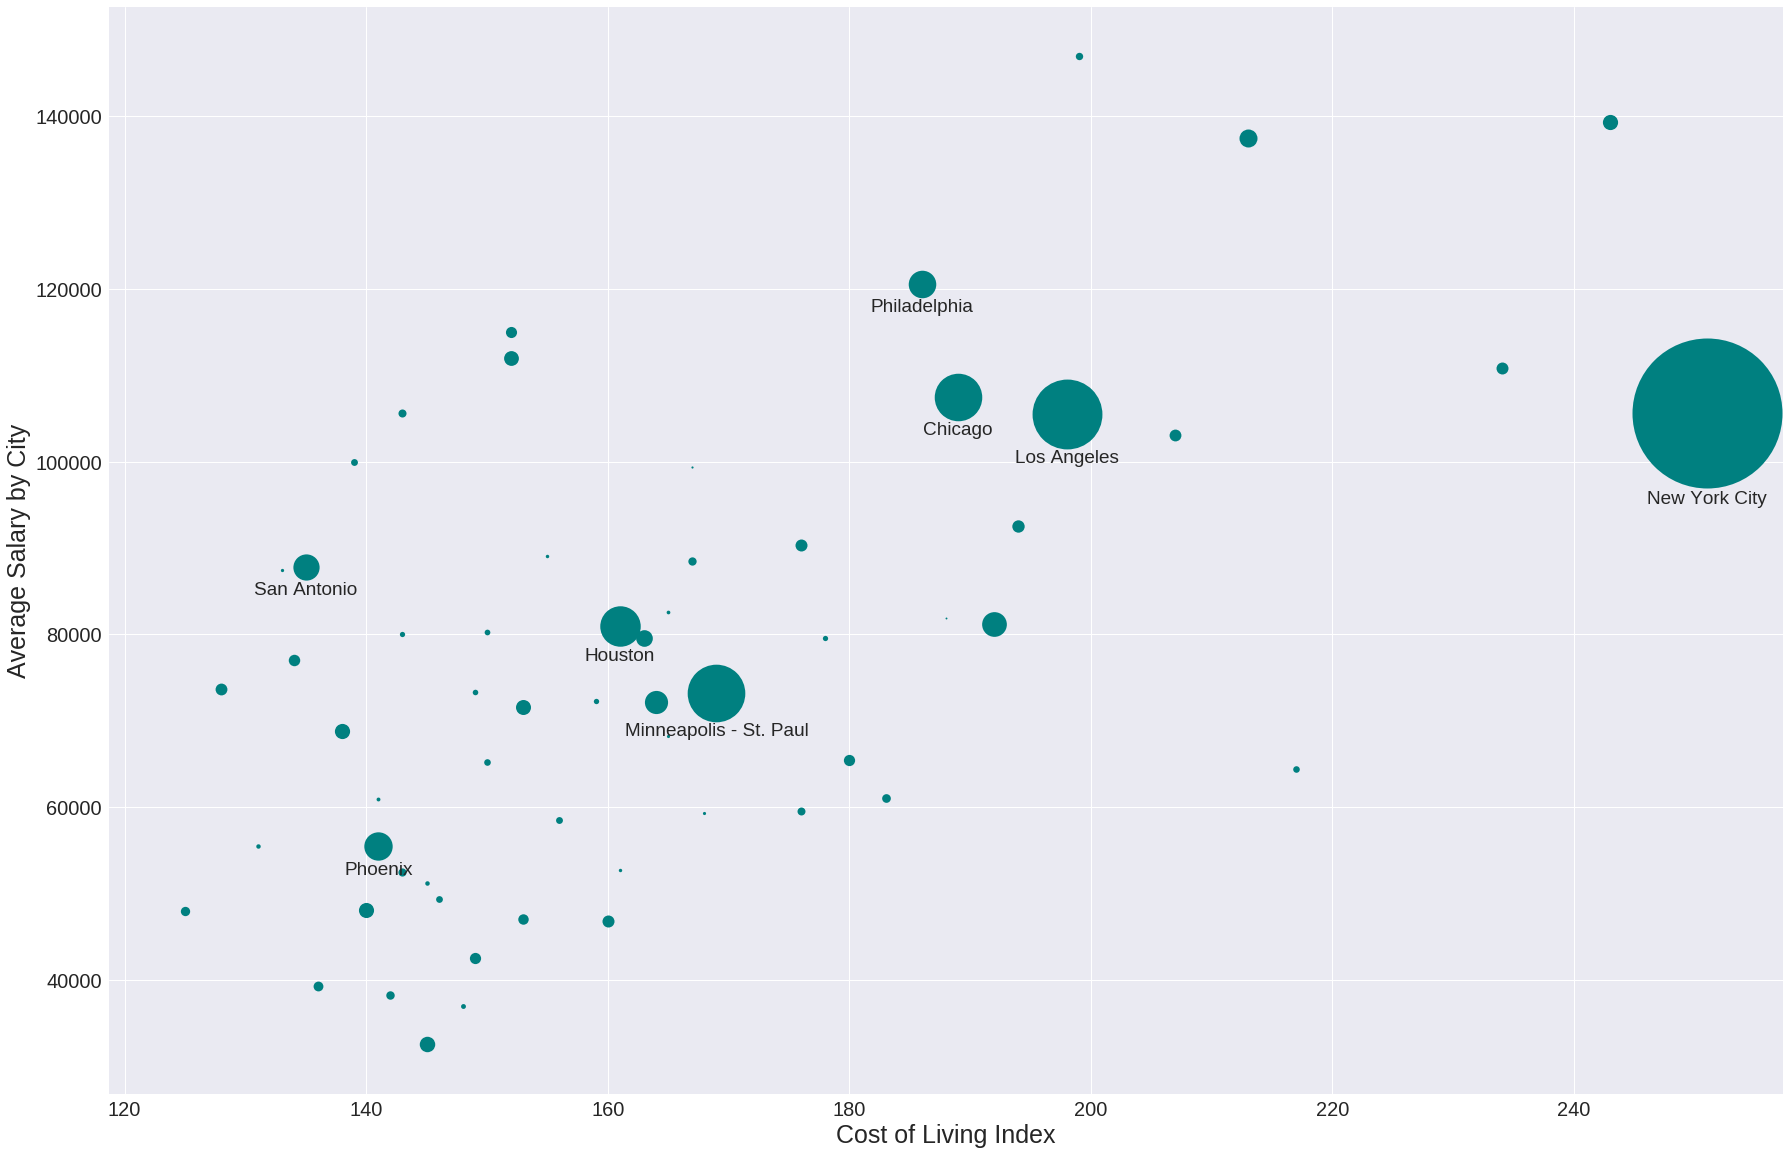

In [90]:

fig = plt.figure(figsize=(30,20))
ax = fig.add_subplot(111)

for (i, e) in enumerate(df_plotting.iterrows()):
    x = df_plotting.cost_index[i]
    y = df_plotting.salary_adjusted[i]
    plt.plot(x, 
             y, 
             marker='.', 
             markersize=s[i],
             color="teal") # replace the color with a classifier and i've got my self a bitchin chart.
    size = (s[i]/float(100) * 3)
    if s[i] > 50:
        ax.text(x, y-s[i]*30, e[0], ha="center", va="top", size=19)


plt.xlabel("Cost of Living Index", fontsize=25)
plt.ylabel("Average Salary by City",fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# I would also like to figure out how to increase the margin

#sns.lmplot('cost_index', 'salary_adjusted',data=df_plotting, fit_reg=False)

## Predicting salaries using Random Forests + Another Classifier

#### Load in the the data of scraped salaries

I am going to start with just yearly salaries. We can modify the model from there.

In [12]:
data = df_clean[df_clean['salary_info'] == 'year']

#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median)

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't _have_ to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries, 

In [13]:
data['is_high'] = data.salary > np.median(data.salary)

/home/roland/anaconda3/envs/ga-immersive/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [14]:
data.head()

,job_title,salary,location,company,description,search_location,salary_info,cost_index,population,salary_adjusted,is_high
0,Data Scientist,75000.0,"New York, NY 10022 (Midtown area)",First Derivatives,Data Scientists explore vast amounts of inform...,New York City,year,251,8538000.0,75000.0,False
1,Data Scientist,102500.0,"New York, NY",MetroPlus Health Plan,The Data Scientist will be tasked with leading...,New York City,year,251,8538000.0,102500.0,True
2,Data Scientist,185000.0,"New York, NY 10005 (Financial District area)",Enterprise Select,"Financial Services data such as transactions, ...",New York City,year,251,8538000.0,185000.0,True
3,Quantitative Analyst,150000.0,"New York, NY 10016 (Gramercy area)",A Priori Investment Management LLC,"Explore complex, unorthodox, and unstructured ...",New York City,year,251,8538000.0,150000.0,True
4,Data Scientist,150000.0,"Jersey City, NJ",MillerCang Agency,The role of the Data Scientist is to develop m...,New York City,year,251,8538000.0,150000.0,True


#### Thought experiment: What is the baseline accuracy for this model?

The accuracy of this model should not be less than 50% if we are splitting the data in half. If we do worse than 50% then our model is essentially backwards and we should reverse our predictions to know do better than 50%.

#### Create a Random Forest model to predict High/Low salary using Sklearn. Start by ONLY using the location as a feature. 

In [127]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

y = data['is_high']
X = pd.get_dummies(data=data['location'])
# I only want to dummy my best cities
X = X[X.sum().nlargest(50).index]
#X['cost_index'] = data['cost_index']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

rfc = RandomForestClassifier(max_depth=10, random_state=22)
#rfc.fit(X_train, y_train)
print(np.mean(cross_val_score(rfc, X_train, y_train,cv=50)))

0.692944444444


In [94]:
# l = zip(X.columns, rfc.feature_importances_)
# print l


#### Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' is in the title or whether 'Manager' is in the title. 
- Then build a new Random Forest with these features. Do they add any value?
- After creating these variables, use count-vectorizer to create features based on the words in the job titles.
- Build a new random forest model with location and these new features included.

In [129]:
## YOUR CODE HEREy = data['is_high']
X = pd.get_dummies(data=data['location'])
# I only want to dummy my best cities
X = X[X.sum().nlargest(10).index]
X['cost_index'] = data['cost_index']
X['is_senior'] = ['senior' in j.lower() for j in data.job_title]
X['is_manager'] = ['manager' in j.lower() for j in data.job_title]
X['is_senior_desc'] = ['senior' in j.lower() for j in data.description]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

rfc = RandomForestClassifier(max_depth=7, random_state=22)
rfc.fit(X_train, y_train)
print(np.mean(cross_val_score(rfc, X_train, y_train,cv=100)))

0.6875


In [132]:
l = zip(X.columns, rfc.feature_importances_)
l.sort()
print(l)

confusion_matrix(y_test, rfc.predict(X_test))

[('Atlanta, GA', 0.0026057706050781003), ('Chicago, IL', 0.017313939447392922), ('Houston, TX', 0.0091091147502371083), ('Los Angeles, CA', 0.0092924555149087231), ('New York, NY', 0.029259481482878734), ('Philadelphia, PA', 0.020008338915637122), ('San Francisco, CA', 0.034115034995887653), ('Seattle, WA', 0.049423313246395886), ('Tucson, AZ', 0.040806708830926651), ('Washington, DC', 0.017239153096910938), ('cost_index', 0.57389834521329386), ('is_manager', 0.059538133211753455), ('is_senior', 0.057169307930882443), ('is_senior_desc', 0.080220902757816376)]


array([[79, 22],
       [29, 73]])

In [135]:
rfc.score(X=X_test,y=y_test)

0.74876847290640391

#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy of the model, as well as any other metrics you feel are appropriate. 

In [121]:
cross_val_score(rfc, X_test, y_test,cv=5)

array([ 0.78571429,  0.53658537,  0.6       ,  0.725     ,  0.7       ])

#### Repeat the model-building process with a non-tree-based method.

In [28]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neural_network import MLPClassifier

X = pd.get_dummies(data=data['location'])
# I only want to dummy my best cities
X = X[X.sum().nlargest(10).index]
X['cost_index'] = data['cost_index']
X['is_senior'] = ['senior' in j.lower() for j in data.job_title]
X['is_manager'] = ['manager' in j.lower() for j in data.job_title]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

rfc = LogisticRegressionCV()
rfc.fit(X_train, y_train)
print(np.mean(cross_val_score(rfc, X_train, y_train,cv=10)))
print(rfc.coef_)
print(rfc.)

0.661451800232
[[ 0.13479844  0.85360291 -0.3918334  -0.04356938  1.01047345  0.68969684
  -0.54530351  0.41420435  0.1134146   0.22014154  0.0097376   0.78302532
  -0.09452724]]


In [ ]:
mlp = MLPClassifier()
np.mean(cross_val_score(mlp, X_train, y_train,cv=10))

### BONUS 

#### Bonus: Use Count Vectorizer from scikit-learn to create features from the job descriptions. 
- Examine using count or binary features in the model
- Re-evaluate your models using these. Does this improve the model performance? 
- What text features are the most valuable? 

In [ ]:
## YOUR CODE HERE